In [659]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

torch.manual_seed(42)
torch.cuda.manual_seed(42)

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [660]:
apple_data = yf.download("IBM", period="max", interval="1d")
apple_data.dropna()
apple_data.reset_index()
apple_data.fillna(method="pad")
apple_data

[*********************100%%**********************]  1 of 1 completed
/tmp/ipykernel_102055/3964589509.py:4: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  apple_data.fillna(method="pad")


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1962-01-02,7.374124,7.374124,7.291268,7.291268,1.541711,407940
1962-01-03,7.291268,7.355003,7.291268,7.355003,1.555187,305955
1962-01-04,7.355003,7.355003,7.278521,7.281708,1.539688,274575
1962-01-05,7.272148,7.272148,7.125558,7.138305,1.509367,384405
1962-01-08,7.131931,7.131931,6.947100,7.004461,1.481068,572685
...,...,...,...,...,...,...
2024-03-18,191.699997,193.229996,190.320007,191.690002,191.690002,5410600
2024-03-19,191.490005,193.580002,190.279999,193.339996,193.339996,5317300
2024-03-20,192.869995,193.979996,191.309998,193.960007,193.960007,3238600


In [661]:
apple_data = apple_data[["Close"]]
apple_data.values

array([[  7.29126787],
       [  7.35500288],
       [  7.28170776],
       ...,
       [193.96000671],
       [191.8999939 ],
       [190.83999634]])

In [662]:
from sklearn.preprocessing import MinMaxScaler

apple_data = apple_data.ffill()
scaler = MinMaxScaler(feature_range=(-1, 1))
apple_data[["Close"]] = scaler.fit_transform(apple_data[["Close"]].values)

In [663]:
apple_data.values

array([[-0.96649664],
       [-0.96586688],
       [-0.9665911 ],
       ...,
       [ 0.87797246],
       [ 0.85761753],
       [ 0.84714372]])

In [664]:
def load_data(stock, look_back):
    data_raw = stock.values # convert to numpy array
    data = []
    
    # create all possible sequences of length look_back
    for index in range(len(data_raw) - look_back): 
        data.append(data_raw[index: index + look_back])
    
    data = np.array(data);
    test_set_size = int(np.round(0.2*data.shape[0]));
    train_set_size = data.shape[0] - (test_set_size);
    
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    
    x_test = data[train_set_size:,:-1]
    y_test = data[train_set_size:,-1,:]
    
    return [x_train, y_train, x_test, y_test]

SEQUENCE_LENGTH = 14
x_train, y_train, x_test, y_test = load_data(apple_data, SEQUENCE_LENGTH)

In [665]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((12519, 13, 1), (12519, 1), (3130, 13, 1), (3130, 1))

In [666]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

x_train = torch.from_numpy(x_train).type(torch.Tensor).to(device=device)
y_train = torch.from_numpy(y_train).type(torch.Tensor).to(device=device)
x_test = torch.from_numpy(x_test).type(torch.Tensor).to(device=device)
y_test = torch.from_numpy(y_test).type(torch.Tensor).to(device=device)

In [667]:
from torch import nn

In [668]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

INPUT_DIM = 1
HIDDEN_DIM = 128
NUMBER_OF_LAYERS = 2
OUTPUT_DIM = 1

class GRU(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(GRU, self).__init__()

        self.hidden_dimensions = hidden_dim
        self.number_of_layers = num_layers
        
        self.gru = nn.GRU(input_size=input_dim, hidden_size=hidden_dim, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(in_features=hidden_dim, out_features=output_dim)
    
    def forward(self, x):
        # Initialize the hidden state with zeros
        h0 = torch.zeros(self.number_of_layers, x.size(0), self.hidden_dimensions).requires_grad_().to(device=device)

        out, _ = self.gru(x, h0)

        # out.size() --> 100, 32, 100
        # out[:, -1, :] --> 100, 100
        out = self.fc(out[:, -1, :])
        
        return out

model_0 = GRU(input_dim=INPUT_DIM, hidden_dim=HIDDEN_DIM, output_dim=OUTPUT_DIM, num_layers=NUMBER_OF_LAYERS).to(device=device)
model_0

GRU(
  (gru): GRU(1, 128, num_layers=2, batch_first=True)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

In [669]:
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model_0.parameters(), lr=0.01)

In [670]:
x_train.size()

torch.Size([12519, 13, 1])

In [671]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)
EPOCHS = 1000

hist = np.zeros(EPOCHS)

for epoch in range(EPOCHS):
    model_0.train()

    y_train_pred = model_0(x_train)
    
    loss = loss_fn(y_train, y_train_pred)
    
    hist[epoch] = loss.item()
    
    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    model_0.eval()
    with torch.inference_mode():
        y_test_pred = model_0(x_test)
        test_loss = loss_fn(y_test, y_test_pred)

    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss} | Test Loss: {test_loss}")

Epoch: 0 | Loss: 0.563005805015564 | Test Loss: 1.0537073612213135


Epoch: 10 | Loss: 0.05891474708914757 | Test Loss: 0.09006887674331665
Epoch: 20 | Loss: 0.012745080515742302 | Test Loss: 0.025286830961704254
Epoch: 30 | Loss: 0.0048583191819489 | Test Loss: 0.015774300321936607
Epoch: 40 | Loss: 0.002292109653353691 | Test Loss: 0.02443661354482174
Epoch: 50 | Loss: 0.0009008829365484416 | Test Loss: 0.0013694214867427945
Epoch: 60 | Loss: 0.00036466788151301444 | Test Loss: 0.0024607127998024225
Epoch: 70 | Loss: 0.0002597456914372742 | Test Loss: 0.002019815379753709
Epoch: 80 | Loss: 0.00027345895068719983 | Test Loss: 0.002032974734902382
Epoch: 90 | Loss: 0.0002319117629667744 | Test Loss: 0.0024219455663114786
Epoch: 100 | Loss: 0.0002247332886327058 | Test Loss: 0.001732560689561069
Epoch: 110 | Loss: 0.00021121380268596113 | Test Loss: 0.001598280156031251
Epoch: 120 | Loss: 0.00020317219605203718 | Test Loss: 0.0014095602091401815
Epoch: 130 | Loss: 0.0001946570846484974 | Test Loss: 0.001192434225231409
Epoch: 140 | Loss: 0.00018660927889

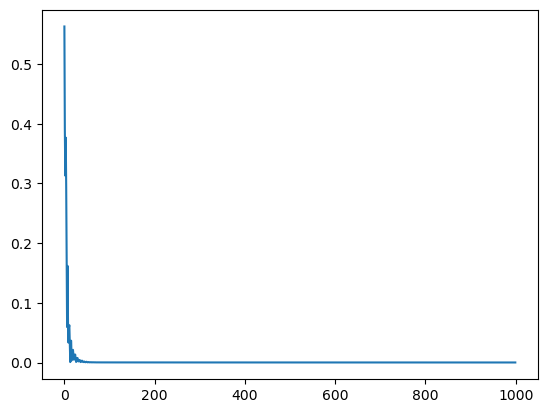

In [672]:
plt.plot(hist)

In [673]:
with torch.inference_mode():
    y_test_pred = model_0(x_test)
    test_loss = loss_fn(y_test, y_test_pred)

y_test_pred = scaler.inverse_transform(y_test_pred.detach().cpu().numpy())
y_test = scaler.inverse_transform(y_test.detach().cpu().numpy())
test_loss

tensor(0.0005, device='cuda:0')

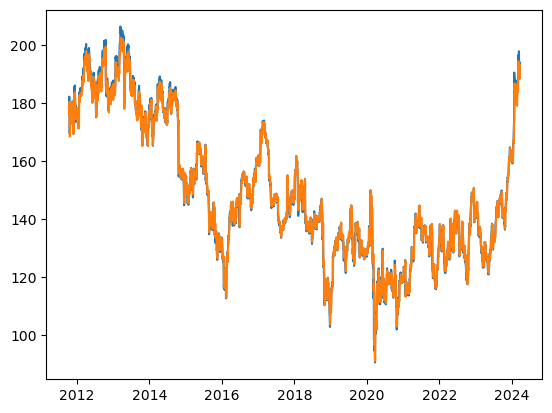

In [674]:
plt.plot(apple_data[len(apple_data) - len(y_test):].index, y_test)
plt.plot(apple_data[len(apple_data) - len(y_test):].index, y_test_pred)

In [675]:
apple_data.values

array([[-0.96649664],
       [-0.96586688],
       [-0.9665911 ],
       ...,
       [ 0.87797246],
       [ 0.85761753],
       [ 0.84714372]])